In [1]:
import numpy as np
import matplotlib.pyplot as plt
from flow_decomposer import FlowDecomposition
from flow_regression import FlowRegression

Toy data preparation.

In [2]:


#############################################
# Test example using mixed Lorenz systems   #
#############################################

def simulate_lorenz(initial, sigma=10, rho=28, beta=8/3, dt=0.01, steps=1000):
    """
    Simulate a Lorenz attractor using Euler integration.
    Returns an array of shape (steps, 3).
    """
    trajectory = np.empty((steps, 3))
    trajectory[0] = initial
    for i in range(1, steps):
        x, y, z = trajectory[i-1]
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        trajectory[i] = trajectory[i-1] + dt * np.array([dx, dy, dz])
    return trajectory

steps = 10000

# Simulate three independent Lorenz attractors.
traj1 = simulate_lorenz(initial=[1.0, 1.0, 1.0], steps=steps)
traj2 = simulate_lorenz(initial=[0.1, -1.0, 1.0], steps=steps)
traj3 = simulate_lorenz(initial=[0.5, 0.5, 0.0], steps=steps)

# Stack the three trajectories horizontally.
# This yields a latent data matrix of shape (steps, 9) [3 systems x 3 dimensions each].
X_latent = np.hstack([traj1, traj2, traj3])

M = np.random.randn(X_latent.shape[1], 20)  

# Mix the latent signals to generate the observed data.
X_mixed = X_latent @ M  # shape (steps, observed_dim)
X_mixed = (X_mixed - X_mixed.mean(axis=0))/X_mixed.std(axis=0)


`FlowDecomposition` usage example. Decomposition of mixed Lorenz dynamics.

In [17]:

# Initialization parameters for FlowDecomposition.
init_params = {
    "input_dim": 20, 
    "proj_dim": 2,
    "n_components": 3,        
    "num_delays": 0,
    "delay_step": 0,
    "model": "linear",
    "subtract_autocorr": False,
    "device": "cpu",
    "data_device": "cpu",
    "optimizer": "Adagrad",
    "learning_rate": 0.1,
    "random_state": None
}

# Fit parameters.
fit_params = {
    "sample_size": 150,
    "library_size": 1000,
    "exclusion_rad": 20,
    "time_intv": 80,
    "num_epochs": 500,
    "num_rand_samples": 32,
    "batch_size": 32,
    "method": "knn",
    "nbrs_num": 16,
    "theta": 5,
    "beta": 0,
    "optim_policy": "range",
    "mask_size": None
}

fd = FlowDecomposition(**init_params)
fd.fit(X_mixed, **fit_params)

Epoch 1/500, Loss: 0.8959, ccm_loss: 0.8959, h_norm_loss: 0.8656
Epoch 2/500, Loss: 0.8685, ccm_loss: 0.8685, h_norm_loss: 0.8036
Epoch 3/500, Loss: 0.8554, ccm_loss: 0.8554, h_norm_loss: 0.8003
Epoch 4/500, Loss: 0.7896, ccm_loss: 0.7896, h_norm_loss: 0.8046
Epoch 5/500, Loss: 0.8089, ccm_loss: 0.8089, h_norm_loss: 0.8099
Epoch 6/500, Loss: 0.7967, ccm_loss: 0.7967, h_norm_loss: 0.8324
Epoch 7/500, Loss: 0.7250, ccm_loss: 0.7250, h_norm_loss: 0.8249
Epoch 8/500, Loss: 0.7141, ccm_loss: 0.7141, h_norm_loss: 0.8204
Epoch 9/500, Loss: 0.7392, ccm_loss: 0.7392, h_norm_loss: 0.8218
Epoch 10/500, Loss: 0.6494, ccm_loss: 0.6494, h_norm_loss: 0.8297
Epoch 11/500, Loss: 0.6271, ccm_loss: 0.6271, h_norm_loss: 0.8348
Epoch 12/500, Loss: 0.5992, ccm_loss: 0.5992, h_norm_loss: 0.8413
Epoch 13/500, Loss: 0.5888, ccm_loss: 0.5888, h_norm_loss: 0.8302
Epoch 14/500, Loss: 0.6192, ccm_loss: 0.6192, h_norm_loss: 0.8269
Epoch 15/500, Loss: 0.6182, ccm_loss: 0.6182, h_norm_loss: 0.8218
Epoch 16/500, Loss:

In [18]:
unmixed = fd.predict(X_mixed)

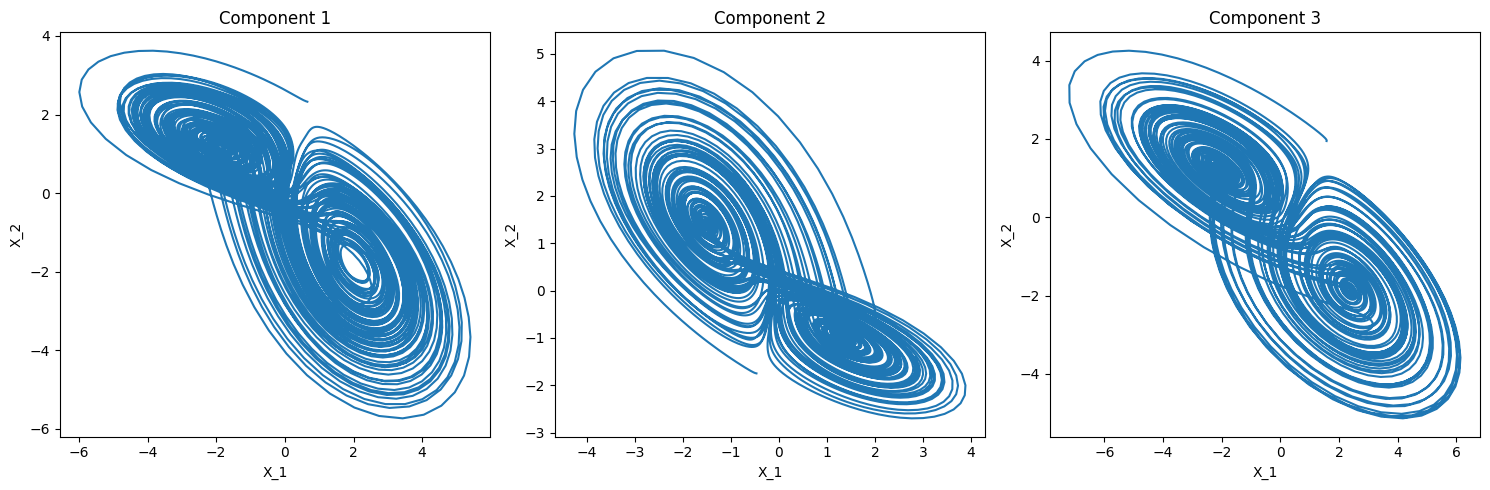

In [21]:

fig, axes = plt.subplots(nrows=1, ncols=unmixed.shape[1], figsize=(15, 5))
for i in range(unmixed.shape[1]):
    axes[i].plot(unmixed[:, i, 0], unmixed[:, i, 1])
    axes[i].set_title(f'Component {i+1}')
    axes[i].set_xlabel('X_1')
    axes[i].set_ylabel('X_2')
plt.tight_layout()
plt.show()

`FlowRegression` usage example. Projecting mixed Lorenz dynamics onto the space where they cross-map to one of the original Lorenz systems.

In [3]:

# Initialization parameters for FlowRegression.
init_params = {
    "input_dim": 20, 
    "proj_dim": 2,
    "num_delays": 3,
    "delay_step": 10,
    "model": "linear",
    "subtract_autocorr": False,
    "device": "cpu",
    "data_device": "cpu",
    "optimizer": "Adagrad",
    "learning_rate": 0.01,
    "random_state": None
}

# Fit parameters.
fit_params = {
    "sample_size": 150,
    "library_size": 1000,
    "exclusion_rad": 20,
    "time_intv": 80,
    "num_epochs": 500,
    "num_rand_samples": 32,
    "batch_size": 32,
    "method": "knn",
    "nbrs_num": 16,
    "theta": 5,
    "beta": 0,
    "optim_policy": "range"

}
y = traj1[:,:]
#y = np.arange(0,10000)[:,None]

fd = FlowRegression(**init_params)
fd.fit(X=X_mixed, Y=y, **fit_params)

Epoch 1/500, Loss: 0.8367, ccm_loss: 0.8367, h_norm_loss: 0.8688
Epoch 2/500, Loss: 0.7004, ccm_loss: 0.7004, h_norm_loss: 0.8576
Epoch 3/500, Loss: 0.5509, ccm_loss: 0.5509, h_norm_loss: 0.8484
Epoch 4/500, Loss: 0.4811, ccm_loss: 0.4811, h_norm_loss: 0.8424
Epoch 5/500, Loss: 0.4253, ccm_loss: 0.4253, h_norm_loss: 0.8363
Epoch 6/500, Loss: 0.3678, ccm_loss: 0.3678, h_norm_loss: 0.8320
Epoch 7/500, Loss: 0.3291, ccm_loss: 0.3291, h_norm_loss: 0.8294
Epoch 8/500, Loss: 0.3088, ccm_loss: 0.3088, h_norm_loss: 0.8275
Epoch 9/500, Loss: 0.2911, ccm_loss: 0.2911, h_norm_loss: 0.8251
Epoch 10/500, Loss: 0.2628, ccm_loss: 0.2628, h_norm_loss: 0.8205
Epoch 11/500, Loss: 0.2329, ccm_loss: 0.2329, h_norm_loss: 0.8182
Epoch 12/500, Loss: 0.2143, ccm_loss: 0.2143, h_norm_loss: 0.8142
Epoch 13/500, Loss: 0.2148, ccm_loss: 0.2148, h_norm_loss: 0.8111
Epoch 14/500, Loss: 0.2098, ccm_loss: 0.2098, h_norm_loss: 0.8097
Epoch 15/500, Loss: 0.1959, ccm_loss: 0.1959, h_norm_loss: 0.8081
Epoch 16/500, Loss:

In [4]:
unmixed = fd.predict(X_mixed)

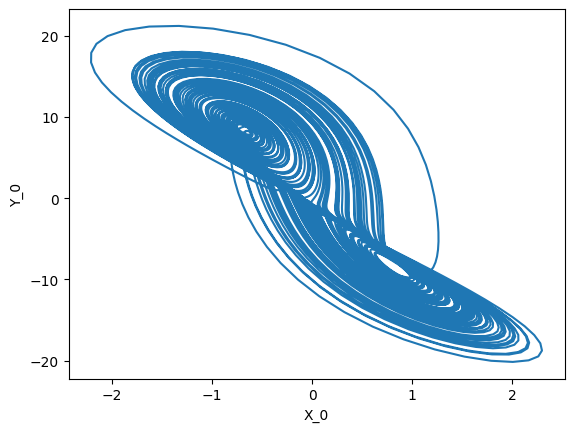

In [10]:
plt.plot(unmixed[:,0,0],y[:,0])
plt.xlabel('X_0')
plt.ylabel('Y_0')
plt.show()